In [1]:
# ALLESFITTER #
from __future__ import print_function, division, absolute_import
import allesfitter
#::: plotting settings
import seaborn as sns
sns.set(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_context(rc={'lines.markeredgewidth': 1})

#::: modules
import os, sys
import glob #to delete files and folders
from multiprocessing import cpu_count
if sys.version_info[0] == 3: # for Python3
    from tkinter import Tk, filedialog
elif sys.version_info[0] == 2: # for Python2
    from Tkinter import Tk
    import tkFileDialog as filedialog
import warnings
def custom_formatwarning(msg, *args, **kwargs):
    return str(msg) + '\n'
warnings.formatwarning = custom_formatwarning
    
#::: allesfitter modules
#::: somehow jupyter notebooks don't allow relative imports, so it needs a little hack...
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
import allesfitter
from allesfitter.utils.latex_printer import round_txt_separately
from allesfitter.priors.transform_priors import get_cosi_from_i, get_Rsuma_from_a_over_Rstar, get_Rsuma_from_Rstar_over_a
from allesfitter.priors.estimate_noise import estimate_noise

%load_ext autoreload
%autoreload 2
#-----------------------------------------------------------#

import math
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import csv

from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.constants
from astropy.constants import R_sun, M_sun, R_jup,  M_jup, R_earth, au, G

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt
import matplotlib.gridspec as gridspec
import requests

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

import eleanor
#eleanor.Update()

import re


! WARNING:
 The global colormaps dictionary is no longer considered public API.
type: <class 'matplotlib.cbook.deprecation.MatplotlibDeprecationWarning'>, file: /home/luke740/anaconda3/lib/python3.6/_collections_abc.py, line: 666


In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results/'

## Construct Targetlist:
### NASA API Database and list of stale targets:

In [ ]:
# PULLS DATA FROM NASA API TABLE = Exoplanets:
# ---------------------------------- #                                                                                                         HOST        NAME    RA DEC    T_0       -\delta T_0    +\delta T_0     P        -\delta P     +\delta P        e         -\delta e       +\delta e         a       -\delta a       +\delta a       i        -\delta i      +\delta i       M      -\delta M    +\delta M     R_p   -\delta R_p +\delta R_p   R_s                          depth    duration(D)            TTV                                             
api_url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=pl_hostname,pl_name,ra,dec,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_massj,pl_massjerr1,pl_massjerr2,pl_radj,pl_radjerr1,pl_radjerr2,st_mass,st_masserr1,st_masserr2,st_rad,st_raderr1,st_raderr2,pl_trandep,pl_trandur,rowupdate,pl_ttvflag&order=pl_tranmid&where=pl_discmethod%20like%20%27%25Transit%25%27'
response = requests.get(api_url)
if response.status_code != 200:
    print('Failed to get data:', response.status_code)
else:
    data_API = pd.read_csv(api_url)
    NASA = DataFrame(data_API, columns=['pl_hostname', 'pl_name' , 'ra', 'dec', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbincl', 'pl_orbinclerr1' ,'pl_orbinclerr2', 'pl_massj', 'pl_massjerr1', 'pl_massjerr2', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_rad', 'st_raderr1', 'st_raderr2', 'pl_trandep', 'pl_trandur', 'rowupdate', 'pl_ttvflag'])
    #NASA = NASA[NASA['pl_tranmid'].notna()] #removes any target with no transit midpoint entry
    #df = df.fillna(0) # FILLS IN ALL NaN values with zeros"
print('Length of the NASA API database is', len(NASA))

# LIST OF STALE TARGETS CALCULATED 21/10/2020 #
# ---------------------------------- #  
target_data = pd.read_csv(f'{directory+folderC}'+'stale_targets_3.csv')
#df_targets = DataFrame(target_data, columns=['ra', 'dec', 'pl_hostname', 'pl_name', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_orbper', 'pl_orbpererr1',	'pl_orbpererr2', 'pl_radj', 'st_rad', 'pl_eqt', 'pl_trandep', 'pl_trandur', 'rowupdate', 'pl_ttvflag', 'no_sectors', 'no_transits', 'semi_major', 'semi_major_err', 'eccentricity', 'eccentricity_err', 'inclination', 'inclination_err', 'long_per', 'long_per_err', 'radius', 'radius_err', 'TIC', 'Tmag', 'SNR'])
#df_targets = DataFrame(target_data, columns=['ra', 'dec', 'pl_hostname', 'pl_name', 'TIC', 'Tmag', 'SNR'])
df_targets = DataFrame(target_data, columns=['pl_hostname', 'pl_name', 'TIC', 'Tmag', 'SNR'])
print('Length of the targetlist is', len(df_targets))

Targetlist = NASA.merge(df_targets, how = 'inner', on = ['pl_hostname', 'pl_name'])
Targetlist = Targetlist.drop_duplicates(keep='first', inplace=False, ignore_index=True)
print('The targetlist has length', len(Targetlist))
Targetlist.to_csv('(2021-03-15)_Targetlist.csv')


### TESS web view tool sector information for each target

In [ ]:
# Sectors contains list of each sector and whether a target is observed or not #
# ---------------------------------- #
Sectors = pd.read_csv(f'{directory+folderC}'+'wtv-Stale_Targetlist_Coords_1.csv', delimiter=',', skiprows=61)
#print(len(Sectors))
T = []
O = []
for i in range(0, len(Sectors)):
    ### selects entire row (RA, DEC, S1 to SX) where X is the most recent sector number - 2
    j = np.array(Sectors.iloc[i,0:35])      
    ### replaces camera numbers with a 1 to enable sector counting
    j = np.where(j>0, 1, j)   
    ### removes RA and DEC values from the summation
    total = np.sum(j)-(j[0]+j[1]) 
    T.append(total)
    if total == 0:
        O.append(0)
    else:
        O.append(1)

Sectors['Observed'] = O
Sectors['#Sectors Observed'] = T
#print(len(T))

# Create a Mid-Targetlist containing API data and Sector data for each target #
# ---------------------------------- #
Mid_Targetlist = Targetlist.merge(Sectors, how = 'inner', on = ['ra', 'dec'])
Mid_Targetlist = Mid_Targetlist.drop_duplicates(keep='first', inplace=False, ignore_index=True)
Mid_Targetlist = Mid_Targetlist.fillna(0)
Mid_Targetlist.to_csv('(2021-03-15)_Mid_Targetlist.csv')


In [ ]:
Sectors

In [ ]:
Mid_Targetlist

### SNR re-calculation:
All data for a given target is on a single row in Mid_Targetlist.
As such, by iterating over each row, an SNR value can be calculated.

In [ ]:
# Reconstructed Noise Function #
# ---------------------------------- #
def TESS_NOISE_v2(x):
    read = 10**(x*0.35055351) * 10**(-1.89114391)
    stellar = 10**(0.21560338*x) * 10**(0.09797272)
    sky = 10**(0.3565365*x) * 10**(-1.8803056)
    return np.sqrt(read**2 + stellar**2 + sky**2 + 60**2)

TESS_Noise = []
for i in range(0, len(Mid_Targetlist)):
    Tmag = Mid_Targetlist['Tmag'][i]
    if Tmag == 'Not Found':
        TESS_Noise.append(np.inf)
    elif Tmag == 'not found':
        TESS_Noise.append(np.inf)
    else: 
        TESS_Noise.append(TESS_NOISE_v2(float(Tmag)))
print(len(TESS_Noise))
Mid_Targetlist.insert(37, 'TESS Noise', TESS_Noise, False)


NEW_SNR = []
print(len(Mid_Targetlist))
for i in range(0, len(Mid_Targetlist)):
    Name = Mid_Targetlist['pl_name'][i]
    R_p = Mid_Targetlist['pl_radj'][i]*R_jup # R_p in m
    R_s = Mid_Targetlist['st_rad'][i]*R_sun # R_s in m
    DEPTH_ppm = ((R_p/R_s)**2) * 1000000
                # depth multiplied by 1million to get ppm
    
    Dur_Hours = Mid_Targetlist['pl_trandur'][i] * 24
    N_sec = Mid_Targetlist['#Sectors Observed'][i]
    P = Mid_Targetlist['pl_orbper'][i]
    N_trans = math.ceil((N_sec * 27) / P)
    
    TESS_noise = Mid_Targetlist['TESS Noise'][i]
    
    #print(Name, TESS_noise, DEPTH_ppm)
       
    if Dur_Hours == 0:
        SNR = 0
        print(Name, Tmag, TESS_noise, R_p, R_s, DEPTH_ppm, Dur_Hours, N_sec, P, N_trans, SNR)
        NEW_SNR.append(SNR)
    else:
        SNR = (DEPTH_ppm / TESS_noise) * (np.sqrt((N_trans * Dur_Hours) / 1))
        NEW_SNR.append(SNR)
    #print(Name, Tmag, TESS_noise)
    #print(R_p, R_s, DEPTH_ppm)
    #print(Dur_Hours, N_sec, P, N_trans)
    #print(SNR)
    #print('\n')

#print(NEW_SNR)
print(len(NEW_SNR))
Mid_Targetlist.insert(39, 'New SNR', NEW_SNR, True)

In [ ]:
Mid_Targetlist

In [ ]:
Mid_Targetlist = Mid_Targetlist.fillna(0)
Mid_Targetlist.sort_values(by='New SNR', inplace=True, ascending=False, ignore_index=True)
Complete_Targetlist = Mid_Targetlist

#del Complete_Targetlist['Unnamed: 0']
Complete_Targetlist = Complete_Targetlist.drop_duplicates(keep='first', inplace=False, ignore_index=True)
#Complete_Targetlist.to_csv('Complete_Targetlist.csv', index=None)

print(len(Complete_Targetlist))
print(Complete_Targetlist['Observed'].sum())
Complete_Targetlist.to_csv('(2021-03-15)_Complete_Targetlist.csv')

In [ ]:
Complete_Targetlist

# Initialise from here after imports !
## Read data in and construct results csv file

In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderR = 'Results_(Data_Removal, Broad_P, Fixed_cosi)/'
with open(f'{directory+folderR}'+'Input_and_Fitted_Values_(BrP, Fcosi).csv', 'a', newline='') as s:
            writer = csv.writer(s)
            writer.writerow(['Index','Name', 'Value', 'Mid-transit time', 'Mid-transit_LE', 'Mid-transit_UE', 'Period', 'Period_LE', 'Period_UE', '', 'SNR', 'Spline'])

In [2]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results_(Data_Removal, Broad_P, Fixed_cosi)/'
folderT = 'Test_Planets/'

Complete_Targetlist = pd.read_csv(f'{directory+folderC}'+'(2021-04-21)_Complete_Targetlist_(NO_TOI).csv')

In [ ]:
print(np.count_nonzero(Complete_Targetlist['pl_tranmid']))
print(np.count_nonzero(Complete_Targetlist['pl_orbsmax']))
print(np.count_nonzero(Complete_Targetlist['pl_radj']))
print(np.count_nonzero(Complete_Targetlist['st_rad']))
print('\n')
print(np.count_nonzero(Complete_Targetlist['pl_massj']))
print(np.count_nonzero(Complete_Targetlist['st_mass']))
print(np.count_nonzero(Complete_Targetlist['st_masserr1']))
print(np.count_nonzero(Complete_Targetlist['st_masserr2']))
print('\n')
print(np.count_nonzero(Complete_Targetlist['pl_orbper']))
print(np.count_nonzero(Complete_Targetlist['pl_orbpererr1']))
print(np.count_nonzero(Complete_Targetlist['pl_orbpererr2']))

print(np.count_nonzero(Complete_Targetlist['pl_trandur']))

In [ ]:
NAME = ['K2-261 b']
for i in NAME:
    index = Complete_Targetlist.index[Complete_Targetlist['pl_name'] == f'{i}'][0]
    TIC = Complete_Targetlist['TIC'][index]
    print(f'{i} has index', index, 'and TIC ID:', TIC)
    SNR = Complete_Targetlist['SNR'][index]
    print('Target has signal-to-noise ratio (SNR) of:', SNR)
    
    #print(Complete_Targetlist.iloc[index])
    P = Complete_Targetlist['pl_orbper'][index]
    P_s = Complete_Targetlist['pl_orbper'][index] * (24*60*60) * u.second
    Dur = Complete_Targetlist['pl_trandur'][index]
    print('Target has period:', P, 'days or', P_s, 'and transits for', Dur, 'days.')
    
    a = Complete_Targetlist['pl_orbsmax'][index]
    print('Target has semi-major separation axis value of:', a)
    
    M_p = Complete_Targetlist['st_mass'][index]*M_sun
    print('Target has stellar mass value of:', M_p)
    
    R_p = Complete_Targetlist['pl_radj'][index]*R_jup
    print('Target has planetary radius of:', R_p, '=', R_p/R_jup, 'R_J')
    
    R_s = Complete_Targetlist['st_rad'][index]*R_sun
    print('Target has stellar radius of:', R_s, '=', R_s/R_sun, r'R_\odot')
    
    a_1 = ( ( G*M_p*(P_s**2) ) / (4*np.pi**2) )**(1/3)
    #a_1 = ((G*M_p*P_s**2) / 4*np.pi**2)**(1/3)
    print('The semi-major separation axis is;', a_1, '=', a_1/au, 'AU')
    print('Estimate for b_rsuma is;', (R_p + R_s) / a_1)

KELT-1 b KELT-1 KELT-1
/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/Results_(Data_Removal, Broad_P, Fixed_cosi)/(6)_(hybrid_spline)_(Wide_Window)(2)_KELT-1 b/
-1572824.0000000002 m 79356120.0 m 2287744.0 m
0.0 m 1015722000.0 m 27828000.0 m
Found star in Sector(s) 17
No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1130/1130 [00:26<00:00, 42.99it/s]


[143, 148, 151, 952, 953, 954, 968, 969, 970]
9


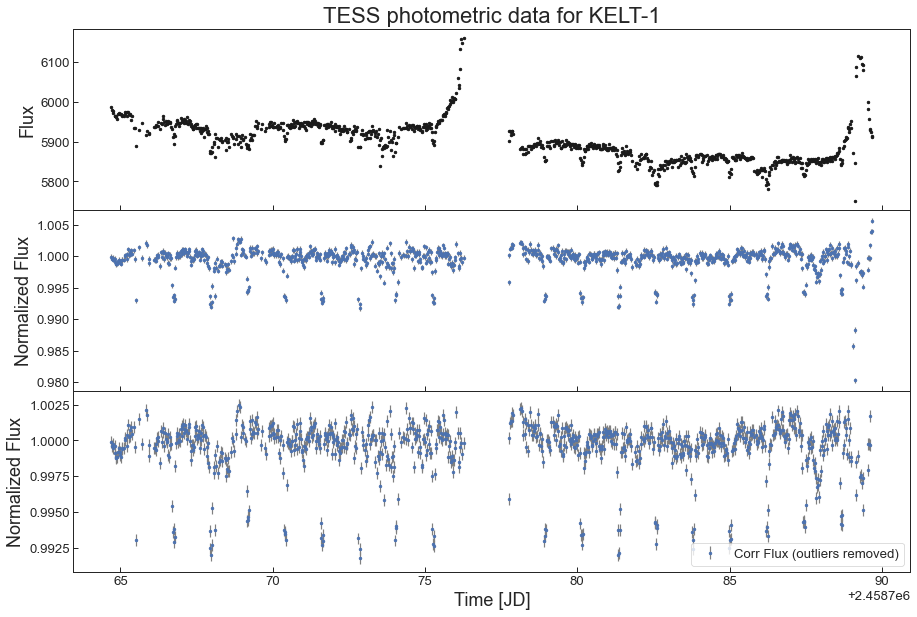

Data begins at 2458764.703000216 and initial midtransit is at 2455914.1628
Periods elapsed are 2341.2791969667405 which rounded is 2341
Upper Midtransit bound estimate is: 0.037415000000000004
Lower Midtransit bound estimate is: -0.037315


Semi_major axis values are: -23935659.312000003 m 3689083491.462 m 23935659.312000003 m
Stellar mass valus are 0.0 kg 2.6247010293214275e+30 kg 5.965229612094153e+28 kg
0.296842866943631 0.011044708480094907



allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2455914.1628
	shifted epoch: 2458776.538214
	shifted by 2351 periods
KELT-1


allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2455914.1628
	shifted epoch: 2458776.538214
	shifted by 2351 periods

Settings:
--------------------------

user-given:                   
companions_phot                ['b'

100%|██████████| 26/26 [00:00<00:00, 49.69it/s]




allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2455914.1628
	shifted epoch: 2458776.538214
	shifted by 2351 periods

Running MCMC...
--------------------------

Running on 3 CPUs.

Running full MCMC


100%|██████████| 7500/7500 [1:38:59<00:00,  1.26it/s]



Time taken to run 'emcee' on 3 cores is 1.65 hours

Acceptance fractions:
--------------------------
[0.45306667 0.45573333 0.46093333 0.44693333 0.44533333 0.44573333
 0.44386667 0.45453333 0.4508     0.45706667 0.4508     0.45893333
 0.4464     0.44186667 0.45106667 0.4452     0.45333333 0.4568
 0.45706667 0.46253333 0.44213333 0.45093333 0.4472     0.4432
 0.43293333 0.42746667 0.45146667 0.4544     0.44266667 0.4456
 0.45426667 0.45266667 0.4412     0.45333333 0.45493333 0.4532
 0.45053333 0.4552     0.43293333 0.4376     0.44533333 0.4604
 0.4432     0.44786667 0.45186667 0.448      0.45706667 0.44333333
 0.4556     0.44906667 0.45026667 0.45066667 0.4544     0.4568
 0.44773333 0.43786667 0.44853333 0.4464     0.45813333 0.4608
 0.44946667 0.44746667 0.45786667 0.44946667 0.4408     0.45186667
 0.45373333 0.43813333 0.44706667 0.44813333 0.45146667 0.44826667
 0.4444     0.4436     0.45706667 0.45106667 0.44786667 0.45066667
 0.44946667 0.45226667 0.4552     0.4492     0.454     

  0%|          | 0/26 [00:00<?, ?it/s]

Autocorrelation times:
	 parameter                      tau (in steps)       Chain length (in multiples of tau)
	 b_rr                           88.52321486044097    73.4270666767741    
	 b_rsuma                        83.68834054119931    77.66912281884818   
	 b_epoch                        79.61723809377725    81.64061145080125   
	 b_period                       78.48151458490541    82.82205095529801   
	 host_ldc_q1_KELT-1             96.8517513894786     67.11288032222535   
	 host_ldc_q2_KELT-1             87.59953372801964    74.20130819624336   
	 ln_err_flux_KELT-1             78.77346048285729    82.51510039240351   

Succesfully converged! All chains are at least 30x the autocorrelation length.



100%|██████████| 26/26 [00:09<00:00,  2.61it/s]


File "params_star.csv" not found. Cannot derive final parameters.

Orbital plots could not be produced.

Done. For all outputs, see /home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/Results_(Data_Removal, Broad_P, Fixed_cosi)/(6)_(hybrid_spline)_(Wide_Window)(2)_KELT-1 b/results 




allesfitter version
--------------------------

v1.1.2

Shifting epochs into the data center:
--------------------------

Companion b
	input epoch: 2455914.1628
	shifted epoch: 2458776.538214
	shifted by 2351 periods


100%|██████████| 26/26 [00:09<00:00,  2.61it/s]


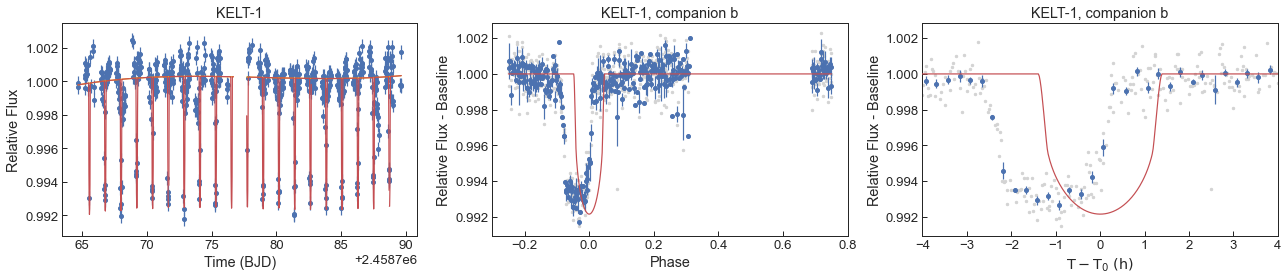

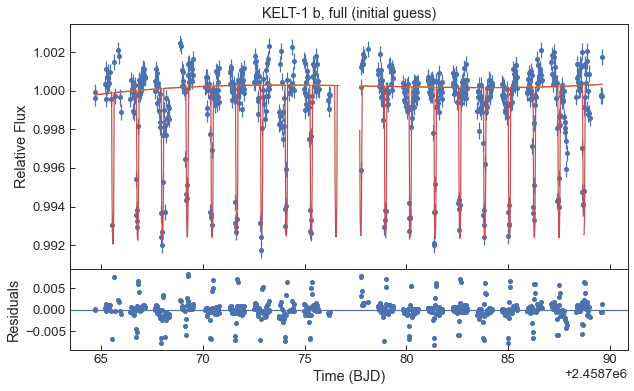

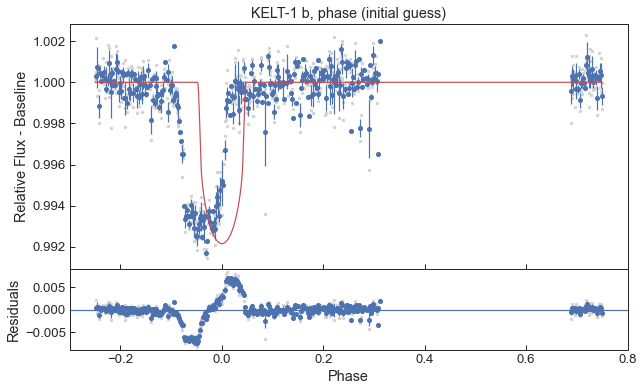

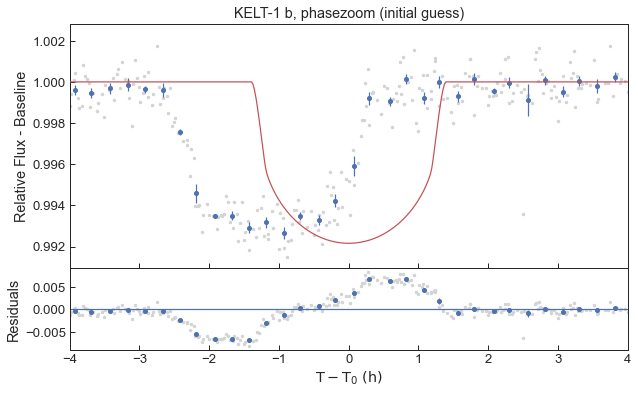

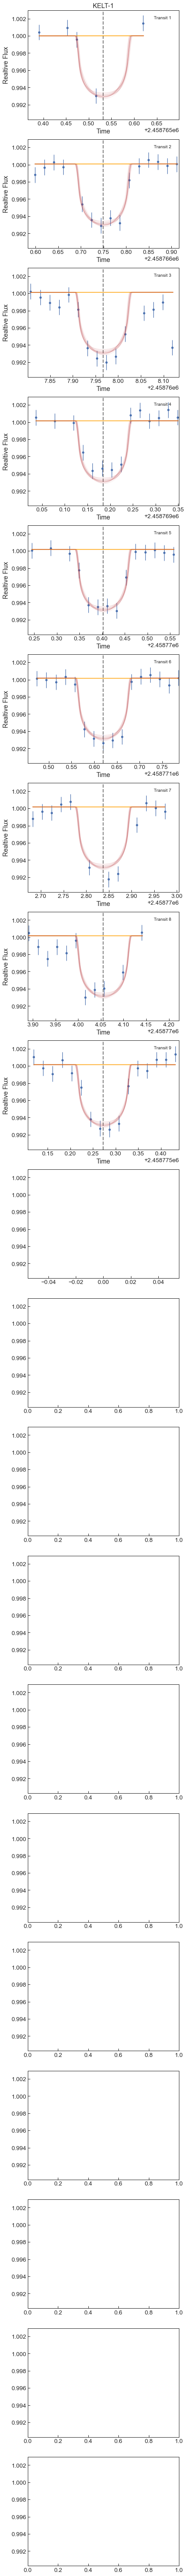

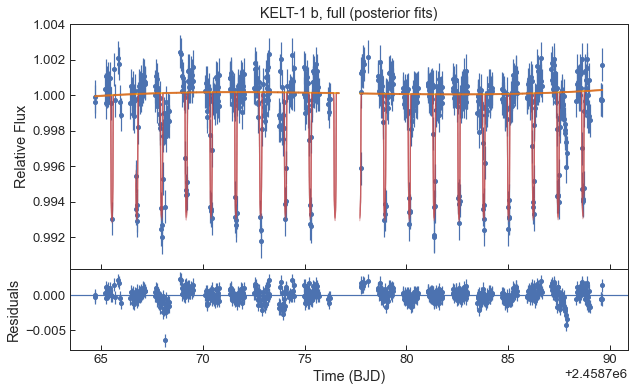

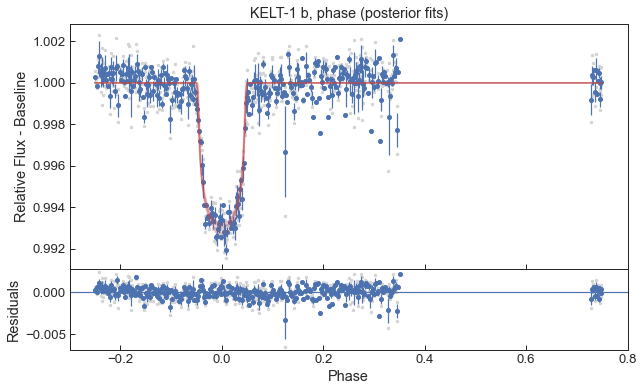

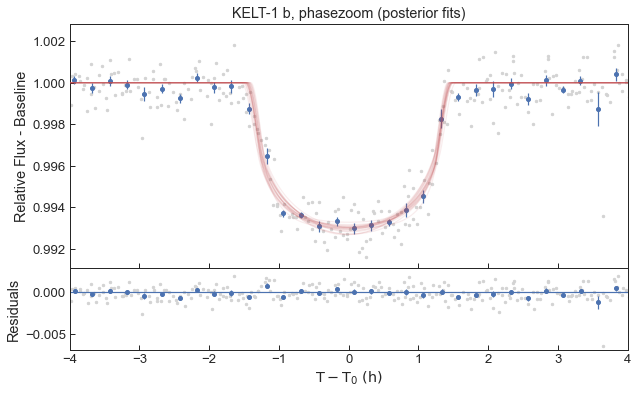

In [4]:
count=6
Spline = 'hybrid_spline'
#Spline = 'sample_GP_real'
while count <= 6: 
    if Complete_Targetlist['Observed'][count] == 0:
        name = Complete_Targetlist.iloc[count]['pl_name']
        print(f'Target {name} has not yet been observed')
        count=count+1 # allows me to execute loop 
        pass

    else:
        name = Complete_Targetlist.iloc[count]['pl_name']
        Name = name[:-2]
        Name_NS = re.sub('\s+', '_', f'{Name}')
        Comp = name[-1:]
        print(name, Name, Name_NS)
        name_index = Complete_Targetlist.index[Complete_Targetlist['pl_name']==name][0]
        TIC_ID = Complete_Targetlist.iloc[count]['TIC']
        SNR = Complete_Targetlist.iloc[count]['New SNR']
        filepath = f'({count})_({Spline})_(Wide_Window)(2)_{name}/'
        path = os.path.join(directory,folderR,filepath)
        print(path)
        #print('The count is:', count)
        count=count+1 # allows me to execute loop 
        #print('The next count will be:', count)
        try:  
            os.makedirs(path, exist_ok=True)  
        except OSError as error:  
            print(error) 
            
        # b_rr
        #r_p = Complete_Targetlist['pl_radj'][name_index]
        R_p = Complete_Targetlist['pl_radj'][name_index]*R_jup
        R_pm = Complete_Targetlist['pl_radjerr2'][name_index]*R_jup 
        R_pp = Complete_Targetlist['pl_radjerr1'][name_index]*R_jup 
        if R_pm ==0:
            R_pe = R_pp
        elif R_pp ==0:
            R_pe = R_pm
        else:
            R_pe = (R_pp - R_pm) / 2
        print(R_pm, R_p, R_pp)

        #r_s = Complete_Targetlist['st_rad'][name_index]
        R_s = Complete_Targetlist['st_rad'][name_index]*R_sun
        R_sm = Complete_Targetlist['st_raderr2'][name_index]*R_sun 
        R_sp = Complete_Targetlist['st_raderr1'][name_index]*R_sun 
        if R_sm ==0:
            R_se = R_sp
        elif R_sp ==0:
            R_se = R_sm
        else:
            R_se = (R_sp - R_sm) / 2
        R_p_s = R_p / R_s
        R_p_se = R_p_s * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2)
        Lb_rr = R_p_s - 5*R_p_se #lower bound
        if Lb_rr <= 0:
            Lb_rr = 0.001
        else:
            Lb_rr = Lb_rr
        Ub_rr = R_p_s + 5*R_p_se #upper bound
        print(R_sm, R_s, R_sp)
        #print(R_p_s - R_p_se, R_p_s, R_p_s + R_p_se)
        
        Depth = (R_p_s)**2
        star = eleanor.multi_sectors(tic = TIC_ID, sectors='all')
        #print(star)

        data = []
        TIME_arr = []
        NCORR_FLUX_arr = []
        NCORR_FLUX_ERR_arr = []
        
        for s in star:
            datum = eleanor.TargetData(s, height=15, width=15, bkg_size=31,
                                  do_psf=True, do_pca=True, regressors='corner')
            data.append(datum) # <-- len(data) equals the number of sectors  

        # datum is an eleanor.Targetdata object and data is a list of these.

        fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(15,10)) 
        for sector, datum in enumerate(data):
            q = datum.quality == 0

            avg_sector_flux_R = np.median(datum.raw_flux[q])
            avg_sector_flux_C = np.median(datum.corr_flux[q])

            '''datum.X[q] are the lists containing the respective values for X'''

            TIME = datum.time[q]+2457000
            RAW = datum.raw_flux[q]
            RAW_E = np.sqrt(datum.raw_flux[q])/ np.sqrt(len(datum.raw_flux[q]))
            NRAW = datum.raw_flux[q] / np.nanmedian(datum.raw_flux[q])
            NRAW_E = np.sqrt(datum.raw_flux[q]) / (np.nanmedian(datum.raw_flux[q])*np.sqrt(len(datum.raw_flux[q])))
            NCORR = datum.corr_flux[q]/np.nanmedian(datum.corr_flux[q])
            NCORR_E = np.sqrt(datum.corr_flux[q])/ (np.nanmedian(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q])))

            INDICES = []
            for i in range(0, len(datum.corr_flux[q])):
                N_corrF = NCORR[i]
                N_corrFerr = (np.sqrt(datum.corr_flux[q])/ (np.nanmedian(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q]))))[i]

                if N_corrF >= 1+(6*np.abs(N_corrFerr)):
                    INDICES.append(i)
                elif N_corrF <= 1-(Depth + 6*np.abs(N_corrFerr)): 
                    INDICES.append(i)
                elif N_corrF < 0:
                    INDICES.append(i)
            print(INDICES)
            print(len(INDICES))

            TIME_d = np.delete(TIME, INDICES)
            NCORR_r = NCORR[INDICES]
            NCORR_d = np.delete(NCORR, INDICES)
            NCORR_E_d = np.delete(NCORR_E, INDICES)
            
            for i in TIME_d:
                TIME_arr.append(i)
            for j in NCORR_d:
                NCORR_FLUX_arr.append(j)
            for k in NCORR_E_d:
                NCORR_FLUX_ERR_arr.append(k)

            ax[0].errorbar(TIME, RAW, yerr=RAW_E, xerr=None, fmt='k.' ,ecolor='gray', label='Raw Flux')
            ax[1].errorbar(TIME, NCORR, yerr=NCORR_E, xerr=None, fmt='b.' ,ecolor='gray', label='Corr Flux')
            ax[2].errorbar(TIME_d, NCORR_d, yerr=NCORR_E_d, xerr=None, fmt='b.' ,ecolor='gray', label='Corr Flux (outliers removed)')
            ax[0].set_ylabel('Flux', fontsize=18)
            ax[1].set_ylabel('Normalized Flux', fontsize=18)
            ax[2].set_ylabel('Normalized Flux', fontsize=18)
            ax[2].set_xlabel('Time [JD]', fontsize=18)
            ax[0].set_title(f'TESS photometric data for {Name}', fontsize=22)
        plt.subplots_adjust(hspace=0)
        plt.legend()
        plt.savefig(f'{directory+folderR+filepath+Name}_Raw_and_Corr.png', overwrite=True)
        plt.show()

        for a in ax:
            a.label_outer()

        data_allesfitter = zip(TIME_arr, NCORR_FLUX_arr, NCORR_FLUX_ERR_arr)
        LC_Data = pd.DataFrame(list(data_allesfitter), columns=['Time (JD)', 'Normalised Correlated Flux', 'Normalised Correlated Flux error'])
        LC_Data.to_csv(f'{path}'+f'{Name_NS}.csv', header=False, index=False)
        #LC_Data.to_csv(f'{path}'+f'{name}.csv', header=False, index=False)

        err_corr_flux = np.mean(NCORR_FLUX_ERR_arr)
        #print(err_corr_flux, np.log(err_corr_flux))

        # cos(i)
        i = np.cos(Complete_Targetlist['pl_orbincl'][name_index]*np.pi/180)
        if i == 1:
            print('There is no entry for orbital inclination, estimating cos(i)=0.1')
            i = 0.1
        else:
            i = i

        i_p = np.cos((Complete_Targetlist['pl_orbincl'][name_index] + Complete_Targetlist['pl_orbinclerr2'][name_index])*np.pi/180)
        if i_p == 1:
            print('Estimating the upper bound for b_cosi as 0.2')
            i_p = 0.2
        else:
            i_p = i_p

        i_m = np.cos((Complete_Targetlist['pl_orbincl'][name_index] + Complete_Targetlist['pl_orbinclerr1'][name_index])*np.pi/180)
        if i_m == 1:
            print('Estimating the lower bound for b_cosi as 0.0')
            i_m = 0.0
        else:
            i_m = i_m
        #print(I_m, I, I_p)
        #print(i_m, i, i_p)
        #print('\n')

        # epoch
        Updated = Complete_Targetlist['rowupdate'][name_index]
        T_0 = Complete_Targetlist['pl_tranmid'][name_index]
        T_0m = Complete_Targetlist['pl_tranmiderr2'][name_index]
        T_0p = Complete_Targetlist['pl_tranmiderr1'][name_index]
        #print(T_0m, T_0, T_0p)
        #print('\n')

        # period
        P = Complete_Targetlist['pl_orbper'][name_index]
        P_m = Complete_Targetlist['pl_orbpererr2'][name_index]
        P_p = Complete_Targetlist['pl_orbpererr1'][name_index]
        #print(P_m, P, P_p)

        ### !!!
        ### MODIFY THIS AS IS THE CAUSE OF SOME ERRORS ###
        ### !!!

        # Midtransit Error Propagation to beginning of TESS data:
        print('Data begins at', TIME_arr[0], 'and initial midtransit is at', T_0)
        elapsed_periods = (TIME_arr[0]-T_0) / P
        eP = math.floor(elapsed_periods)
        print('Periods elapsed are', elapsed_periods, 'which rounded is', eP )
        print('Upper Midtransit bound estimate is:', (T_0p + eP*P_p) )
        print('Lower Midtransit bound estimate is:', (T_0m + eP*P_m) )
        #print(T_0 + (T_0m + eP*P_m) )
        print('\n')

        while TIME_arr[0] < T_0:
            with open(f'{directory+folderR}'+'Input_and_Fitted_Values_(BrP, Fcosi).csv', 'a', newline='') as S:
                writer = csv.writer(S)
                writer.writerow([f'{name_index}',f'{name}', 'NASA', f'{T_0}', f'{T_0m}', f'{T_0p}', f'{P}', f'{P_m}', f'{P_p}', '', 'Up-to-date', f'{Updated}'])
                writer.writerow([' '])
                break
        else:

            # duration
            Dur = Complete_Targetlist['pl_trandur'][name_index]
            #if Dur <= 0.5:
            #    Dur = 0.5
            #else:
            #    Dur = Dur + 0.25
            Window = 2*(2*Dur + 2*np.abs(T_0m + eP*P_m) + 2*np.abs(T_0p + eP*P_p))
            if Window > P:
                VALUE = 'False'
                Window = ''
            else:
                VALUE = 'True'
                Window = Window
                
            # b_rsuma
            a = Complete_Targetlist['pl_orbsmax'][name_index]*au
            a_me = Complete_Targetlist['pl_orbsmaxerr2'][name_index]*au
            a_pe = Complete_Targetlist['pl_orbsmaxerr1'][name_index]*au

            m = Complete_Targetlist['st_mass'][name_index]*M_sun # mass of star in kg
            m_me = Complete_Targetlist['st_masserr2'][name_index]*M_sun
            m_pe = Complete_Targetlist['st_masserr1'][name_index]*M_sun
            if m_me ==0:
                dm = m_pe
            elif m_pe ==0:
                dm = m_me
            else:
                dm = (m_pe - m_me) / 2

            print('Semi_major axis values are:', a_me, a, a_pe)
            print('Stellar mass valus are', m_me, m, m_pe)
            if a == 0:
                print('There is no entry for semi-major axis - estimating this using Keplers Third Law')
                if m == 0:
                    print('With no mass or semi-major axis value, this parameter cannot be estimated')
                else:
                    p = P * (24*60*60) * u.second
                    p_m = P_m * (24*60*60) * u.second
                    p_p = P_p * (24*60*60) * u.second
                    dp = (p_m + p_p) / 2

                    a_1 = ( (G*m*(p**2)) / (4*np.pi**2) )**(1/3)
                    a_1e = (a/3) * np.sqrt( (dm/m)**2 + (2*((dp/p)**2)) )

                    print('Estimate for a is', a_1, 'with error', a_1e)

                    R_a = (R_p + R_s) / a_1
                    R_ae = R_a * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2 + (a_1e/a_1)**2)
                    Lb_rsuma = R_a - 5*R_ae
                    Ub_rsuma = R_a + 5*R_ae
                    if Lb_rsuma <= 0:
                        Lb_rsuma = 0.000001
                    else:
                        Lb_rsuma = Lb_rsuma

                    default_steps = 750
                    default_loops = 2
            else:
                R_a = (R_p + R_s) / a
                R_ae = R_a * np.sqrt((R_pe/R_p)**2 + (R_se/R_s)**2 + ((a_pe - a_me)/(2*a))**2)
                Lb_rsuma = R_a - 5*R_ae
                Ub_rsuma = R_a + 5*R_ae
                if Lb_rsuma <= 0:
                    Lb_rsuma = 0.000001
                else:
                    Lb_rsuma = Lb_rsuma

                default_steps = 0
                default_loops = 0

            print(R_a, R_ae)
            
            Cont_Ratio = Complete_Targetlist['Cont_Factor'][name_index]
            Dilution = Cont_Ratio / (1 + Cont_Ratio)

            with open(f'{directory+folderR+filepath}'+'settings.csv', 'w', newline='') as s:
                writer = csv.writer(s)
                writer.writerow(['#name', '#value'])
                #writer.writerow(['companions_phot', f'{Comp}'])
                writer.writerow(['companions_phot', 'b'])
                writer.writerow(['inst_phot', f'{Name_NS}'])
                writer.writerow(['multiprocess', 'True'])
                writer.writerow(['fast_fit', VALUE])
                writer.writerow(['fast_fit_width', f'{Window}']) #crops data to duration + 0.25days, centered on T_0
                writer.writerow(['secondary_eclipse', 'False'])
                writer.writerow(['phase_curve', 'False'])
                writer.writerow(['shift_epoch', 'True'])
                writer.writerow(['inst_for_b_epoch', 'all'])
                writer.writerow(['mcmc_nwalkers', '100'])
                writer.writerow(['mcmc_total_steps', '7500'])
                writer.writerow(['mcmc_burn_steps', '1000'])
                writer.writerow(['mcmc_thin_by', '1'])
                writer.writerow(['mcmc_pre_run_steps', f'{default_steps}'])
                writer.writerow(['mcmc_pre_run_loops', f'{default_loops}'])
                writer.writerow([f'host_ld_law_{Name_NS}', 'quad'])
                writer.writerow([f'baseline_flux_{Name_NS}', f'{Spline}']) 
                # ^ previously using hybrid_offset

                #writer.writerow([f'baseline_flux_{name}', 'sample_offset'])
                writer.writerow([f'error_flux_{Name_NS}', 'sample'])
                #writer.writerow([f'error_flux_{name}', 'hybrid'])
                writer.writerow([f't_exp_{Name_NS}', '0.0208333'])
                writer.writerow([f't_exp_n_int_{Name_NS}', ' ']) #set to 15
                writer.writerow([f'host_N_spots_{Name_NS}', ' '])
                writer.writerow(['N_flares', ' '])
                writer.writerow(['fit_ttvs', 'False'])
                writer.writerow([f'host_grid_{Name_NS}', 'default'])
                writer.writerow([f'host_shape_{Name_NS}', 'sphere'])

            with open(f'{directory+folderR+filepath}'+'params.csv', 'w', newline='') as p:
                write = csv.writer(p)
                # name, value, standard, bounds (-)(+)
                write.writerow(['#name', 'value', 'fit', 'bounds', 'label', 'unit'])
                write.writerow(['b_rr', R_p_s, 1, f'uniform {Lb_rr} {Ub_rr}', '$R_b / R_\star$', '']) # r_planet / r_star
                write.writerow(['b_rsuma', R_a, 1, f'uniform {Lb_rsuma} {Ub_rsuma}', '$(R_\star + R_b) / a_b$', '']) # r_planet + r_star / a
                #write.writerow(['b_cosi', i, 1, f'uniform 0 1', '$\cos{i_b}$', '']) # cosine of inclination
                write.writerow(['b_cosi', i, 0, '', '$\cos{i_b}$', '']) # cosine of inclination - FIXED PARAMETER
                write.writerow(['b_epoch', f'{T_0}', 1, f'uniform {T_0 + (T_0m + eP*P_m)} {T_0 + (T_0p + eP*P_p)}', '$T_{0;b}$', '$\mathrm{JD}$']) # transit midpoint
                #write.writerow(['b_period', f'{P}', 1, f'uniform {P + 5*P_m} {P + 5*P_p}', '$P_b$', '$\mathrm{d}$']) # orbital period 
                write.writerow(['b_period', f'{P}', 1, f'uniform {P + 100*P_m} {P + 100*P_p}', '$P_b$', '$\mathrm{d}$']) # leave P blank 

                #write.writerow(['b_f_c', ..., 0, f'trunc_normal {} {}', '$\sqrt{e_b} \cos{\omega_b}$') # sqrt(e) cos(omega)
                #write.writerow(['b_f_s', ..., 0, f'trunc_normal {} {}', '$\sqrt{e_b} \sin{\omega_b}$') # sqrt(e) sin(omega)
                write.writerow([f'dil_{Name_NS}', f'{Dilution}', 0, f'trunc_normal {0} {1} {0} {0}', '$D_\mathrm{0}$', '']) # instrument dilution 
                write.writerow([f'host_ldc_q1_{Name_NS}', 0.5, 1, f'uniform {0} {1}', '$q_{1}$', '']) # 
                write.writerow([f'host_ldc_q2_{Name_NS}', 0.5, 1, f'uniform {0} {1}', '$q_{2}$', '']) # 
                write.writerow([f'b_sbratio_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$J_{b}$', '']) # surface brightness ratio
                write.writerow([f'host_geom_albedo_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$A_{\mathrm{geom}; host}$', '']) # geometric albedo star
                write.writerow([f'b_geom_albedo_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$A_{\mathrm{geom}; b}$', '']) # geometric albedo planet
                write.writerow([f'host_gdc_{Name_NS}', 0.0, 0, f'trunc_normal {0} {1} {0} {0}', '$Grav. dark._{b}$', '']) # gravity darkening
                write.writerow([f'ln_err_flux_{Name_NS}', np.log(err_corr_flux), 1, f'trunc_normal -20 0 {np.log(err_corr_flux)} 0.5', '$\ln{\sigma}$', '']) # log error on flux
                # EITHER:
                #write.writerow([f'baseline_offset_flux_{name}', '' , 1, 'uniform', '$\mathrm{gp: \ln{\sigma}}$', '']) # 
                # OR:
                #write.writerow([f'baseline_gp_real_lna_flux_{Name_NS}', 0.0, 1, f'uniform {-15} {15}', '$\mathrm{gp: ln sigma}$', ' ']) # 
                #write.writerow([f'baseline_gp_real_lnc_flux_{Name_NS}', 0.0, 1, f'uniform {-15} {15}', '$\mathrm{gp: ln rho}$', ' '])  


            alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
            inst = f'{Name_NS}'
            print(inst)
            key = 'flux'

            alles.get_initial_guess_stellar_var(inst, key)
            allesfitter.show_initial_guess(f'{directory+folderR+filepath}', do_logprint=True, do_plot=True, return_figs=True)
            
            for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:
                # PLOTS INITIAL GUESSES
                fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
                fig.subplots_adjust(hspace=0)
                #::: alles.plot(...) data and model
                alles.plot(f'{Name_NS}','b',style,mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[0])
                #Nsamples is the number of posterior best fit models plotted. - randomly chosen
                axes[0].set_title(f'{name}, '+style+' (initial guess)')
                #::: alles.plot(...) residuals
                alles.plot(f'{Name_NS}','b',style+'_residuals',mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[1])
                axes[1].axhline(y=0)
                axes[1].set_title('')
                fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(initial).png', bbox_inches='tight')

            allesfitter.mcmc_fit(f'{directory+folderR+filepath}')
            allesfitter.mcmc_output(f'{directory+folderR+filepath}')

            alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
            inst = f'{Name_NS}'
            key = 'flux'
            #::: load the time, flux, and flux_err
            time = alles.data[inst]['time']
            flux = alles.data[inst][key]
            flux_err = alles.data[inst]['err_scales_'+key] * alles.posterior_params_median['err_'+key+'_'+inst]

            for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:
                '''
                # PLOTS INITIAL GUESSES
                fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
                fig.subplots_adjust(hspace=0)
                #::: alles.plot(...) data and model
                alles.plot(f'{Name_NS}','b',style,mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[0])
                #Nsamples is the number of posterior best fit models plotted. - randomly chosen
                axes[0].set_title(f'{name}, '+style+' (initial guess)')
                #::: alles.plot(...) residuals
                alles.plot(f'{Name_NS}','b',style+'_residuals',mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[1])
                axes[1].axhline(y=0)
                axes[1].set_title('')
                fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(initial).png', bbox_inches='tight')
                '''
                
                # PLOTS POSTERIOR FIT VALUES
                fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
                fig.subplots_adjust(hspace=0)
                #::: alles.plot(...) data and model
                alles.plot(f'{Name_NS}','b',style,mode='posterior', Nsamples=20, force_binning=False, ax=axes[0])
                #Nsamples is the number of posterior best fit models plotted. - randomly chosen
                axes[0].set_title(f'{name}, '+style+' (posterior fits)')
                #::: alles.plot(...) residuals
                alles.plot(f'{Name_NS}','b',style+'_residuals',mode='posterior', Nsamples=20, force_binning=False, ax=axes[1])
                axes[1].axhline(y=0)
                axes[1].set_title('')
                fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(fit).png', bbox_inches='tight')

            ### Creates CSV file with input and fitted midtransit and period values ###
            Fit_Results = pd.read_csv(f'{directory+folderR+filepath}results/'+'mcmc_table.csv')
            Fitted_T_0 = Fit_Results['median'][4]
            Fitted_T_0_le = Fit_Results['lower_error'][4]
            Fitted_T_0_ue = Fit_Results['upper_error'][4]

            Fitted_P = Fit_Results['median'][5]
            Fitted_P_le = Fit_Results['lower_error'][5]
            Fitted_P_ue = Fit_Results['upper_error'][5]

            Fitted_brr = Fit_Results['median'][1]
            Fitted_brre = (float(Fit_Results['lower_error'][1]) + float(Fit_Results['upper_error'][1])) / 2
            #Fitted_SNR = (float(Fitted_brr)) / Fitted_brre
            Fitted_SNR = (float(Fitted_brr)) / (2*Fitted_brre)
            # SNR = depth / error on depth = (R_p/R_s)^2 / 2(err(R_p/R_s))

            Updated = Complete_Targetlist['rowupdate'][name_index]
            with open(f'{directory+folderR}'+'Input_and_Fitted_Values_(BrP, Fcosi).csv', 'a', newline='') as S:
                writer = csv.writer(S)
                writer.writerow([f'{name_index}',f'{name}', 'NASA', f'{T_0}', f'{T_0m}', f'{T_0p}', f'{P}', f'{P_m}', f'{P_p}', '', '', f'{Updated}'])
                #writer.writerow([f'{name_index}',f'{name}', 'Input', f'{T_0}', f'{(T_0m + eP*P_m)}', f'{(T_0p + eP*P_p)}', f'{P}', f'{5*P_m}', f'{5*P_p}', '', f'{SNR}', f'{Spline}'])
                writer.writerow([f'{name_index}',f'{name}', 'Input', f'{T_0}', f'{(T_0m + eP*P_m)}', f'{(T_0p + eP*P_p)}', f'{P}', f'{100*P_m}', f'{100*P_p}', '', f'{SNR}', f'{Spline}'])
                writer.writerow([f'{name_index}',f'{name}', 'Fit', f'{Fitted_T_0}', f'-{Fitted_T_0_le}', f'{Fitted_T_0_ue}', f'{Fitted_P}', f'-{Fitted_P_le}', f'{Fitted_P_ue}', '', f'{Fitted_SNR}'])
                writer.writerow([' '])
else:
    pass


## (Manual) MCMC Running

In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results/'
folderT = 'Test_Planets/'

name = 'HD 202772 A b'
Name = 'HD 202772 A'
Name_NS = 'HD_202772_A'
count = 7

filepath = f'({count})_{name}/'
alles = allesfitter.allesclass(f'{directory+folderT+filepath}')
inst = f'{Name_NS}'
key = 'flux'

alles.get_initial_guess_stellar_var(inst, key)
allesfitter.show_initial_guess(f'{directory+folderT+filepath}', do_logprint=True, do_plot=True, return_figs=True)
allesfitter.mcmc_fit(f'{directory+folderT+filepath}')
allesfitter.mcmc_output(f'{directory+folderT+filepath}')

alles = allesfitter.allesclass(f'{directory+folderT+filepath}')
inst = f'{Name}'
key = 'flux'
#::: load the time, flux, and flux_err
time = alles.data[inst]['time']
flux = alles.data[inst][key]
flux_err = alles.data[inst]['err_scales_'+key] * alles.posterior_params_median['err_'+key+'_'+inst]

for style in ['full', 'phase', 'phasezoom',]: #'phasezoom_occ', 'phase_variations'
    # PLOTS INITIAL GUESSES
    fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
    fig.subplots_adjust(hspace=0)
    #::: alles.plot(...) data and model
    alles.plot(f'{Name}','b',style,mode='initial guess', Nsamples=20, force_binning=False, ax=axes[0])
    #Nsamples is the number of posterior best fit models plotted. - randomly chosen
    axes[0].set_title(f'{Name}, '+style)
    #::: alles.plot(...) residuals
    alles.plot(f'{Name}','b',style+'_residuals',mode='initial guess', Nsamples=20, force_binning=False, ax=axes[1])
    axes[1].axhline(y=0)
    axes[1].set_title('')
    fig.savefig(f'{directory+folderT+filepath+name}_'+style+'(initial).png', bbox_inches='tight')
    
    # PLOTS POSTERIOR FIT VALUES
    fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
    fig.subplots_adjust(hspace=0)
    #::: alles.plot(...) data and model
    alles.plot(f'{Name}','b',style,mode='posterior', Nsamples=20, force_binning=False, ax=axes[0])
    #Nsamples is the number of posterior best fit models plotted. - randomly chosen
    axes[0].set_title(f'{Name}, '+style)
    #::: alles.plot(...) residuals
    alles.plot(f'{Name}','b',style+'_residuals',mode='posterior', Nsamples=20, force_binning=False, ax=axes[1])
    axes[1].axhline(y=0)
    axes[1].set_title('')
    fig.savefig(f'{directory+folderT+filepath+name}_'+style+'(fit).png', bbox_inches='tight')

## (Manual) Residual Plotting

In [ ]:
directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results/'
folderT = 'Test_Planets/'

name = 'Kepler-1349 b'
Name = 'Kepler-1349'
Name_NS = 'Kepler-1349'
count = 417

%matplotlib qt

filepath = f'({count})_{name}/'
alles = allesfitter.allesclass(f'{directory+folderR+filepath}')
inst = f'{Name_NS}'
key = 'flux'
#::: load the time, flux, and flux_err
time = alles.data[inst]['time']
flux = alles.data[inst][key]
flux_err = alles.data[inst]['err_scales_'+key] * alles.posterior_params_median['err_'+key+'_'+inst]

allesfitter.show_initial_guess(f'{directory+folderR+filepath}', do_logprint=True, do_plot=True, return_figs=True)

for style in ['full', 'phase', 'phasezoom']: #, 'phasezoom_occ', 'phase_variations']:
            # PLOTS INITIAL GUESSES
            fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
            fig.subplots_adjust(hspace=0)
            #::: alles.plot(...) data and model
            alles.plot(f'{Name_NS}','b',style,mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[0])
            #Nsamples is the number of posterior best fit models plotted. - randomly chosen
            axes[0].set_title(f'{Name}, '+style+' (initial guess)')
            #::: alles.plot(...) residuals
            alles.plot(f'{Name_NS}','b',style+'_residuals',mode='initial_guess', Nsamples=20, force_binning=False, ax=axes[1])
            axes[1].axhline(y=0)
            axes[1].set_title('')
            fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(initial).png', bbox_inches='tight')

            # PLOTS POSTERIOR FIT VALUES
            fig, axes = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'height_ratios': [3,1]}, sharex=True)
            fig.subplots_adjust(hspace=0)
            #::: alles.plot(...) data and model
            alles.plot(f'{Name_NS}','b',style,mode='posterior', Nsamples=20, force_binning=False, ax=axes[0])
            #Nsamples is the number of posterior best fit models plotted. - randomly chosen
            axes[0].set_title(f'{Name}, '+style+' (posterior fits)')
            #::: alles.plot(...) residuals
            alles.plot(f'{Name_NS}','b',style+'_residuals',mode='posterior', Nsamples=20, force_binning=False, ax=axes[1])
            axes[1].axhline(y=0)
            axes[1].set_title('')
            fig.savefig(f'{directory+folderR+filepath+name}_'+style+'_(fit).png', bbox_inches='tight')


### (Manual) Histogram Plotting:

In [ ]:
# 1 Sigma
T0 = 2458558.31287784
delta_T0 = 0.0024
Tee0 = np.random.normal(loc=T0, scale=delta_T0, size=10000)

# 5 Sigma
T1 = 2458558.31313768
delta_T1 = 0.0021
Tee1 = np.random.normal(loc=T1, scale=delta_T1, size=10000)

# Propagated
T2 = 2458558.31301112
delta_T2 = 0.0021
Tee2 = np.random.normal(loc=T2, scale=delta_T2, size=10000)

# Paper (propagated)
T3 = 2458558.31600
delta_T3 = 0.00116
Tee3 = np.random.normal(loc=T3, scale=delta_T3, size=10000)

plt.figure(figsize=(10, 5))
plt.hist(Tee0, 200, lw=3, histtype='step', label=r'Fit from $1\sigma$ priors') 
plt.hist(Tee1, 200, lw=3, histtype='step', label=r'Fit from $5\sigma$ priors')
plt.hist(Tee2, 200, lw=3, histtype='step', label=r'Fit from propagated priors')
plt.hist(Tee3, 200, lw=3, histtype='step', label=r'Paper (propagated)')
plt.title('K2-261 TESS midtransit distributions')
plt.xlabel(r'$T_0$')
plt.ylabel('Frequency (counts)')
plt.legend()
plt.show()

In [ ]:
count=2
Spline = 'hybrid_spline'
while count <= 19:
    if Complete_Targetlist['Observed'][count] == 0:
        name = Complete_Targetlist.iloc[count]['pl_name']
        print(f'Target {name} has not yet been observed')
        count=count+1 # allows me to execute loop 
        pass

    else:
        name = Complete_Targetlist.iloc[count]['pl_name']
        Name = name[:-2]
        Name_NS = re.sub('\s+', '_', f'{Name}')
        Comp = name[-1:]
        print(name, Name, Name_NS)
        name_index = Complete_Targetlist.index[Complete_Targetlist['pl_name']==name][0]
        TIC_ID = Complete_Targetlist.iloc[count]['TIC']
        SNR = Complete_Targetlist.iloc[count]['New SNR']
        filepath = f'({count})_({Spline})_{name}/'
        path = os.path.join(directory,folderR,filepath)
        print(path)
        print('The count is:', count)
        count=count+1 # allows me to execute loop 
        print('The next count will be:', count)
        #try:  
        #    os.makedirs(path, exist_ok=True)  
        #except OSError as error:  
        #    print(error) 

        star = eleanor.multi_sectors(tic = TIC_ID, sectors='all')
        #print(star)
        data = []
        for s in star:
            datum = eleanor.TargetData(s, height=15, width=15, bkg_size=31,
                                  do_psf=True, do_pca=True, regressors='corner')
            data.append(datum) # <-- len(data) equals the number of sectors  

        TIME = []
        NRAW_flux = []
        NRAW_flux_err = []
        NCORRELATED_flux = []
        NCORRELATED_flux_err = []
        NPCA_flux = []
        NPCA_flux_err = []
        NPSF_flux = []

        fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15,5)) 
        for sector, datum in enumerate(data):
            q = datum.quality == 0
            #print(sector)
            #print(datum)
            TIME.append(datum.time[q]+2457000)
            NRAW_flux.append(datum.raw_flux[q]/np.median(datum.raw_flux[q]))
            NRAW_flux_err.append(np.sqrt(datum.raw_flux[q])/(np.median(datum.raw_flux[q])*np.sqrt(len(datum.raw_flux[q]))))
            NCORRELATED_flux.append(datum.corr_flux[q]/np.median(datum.corr_flux[q]))
            NCORRELATED_flux_err.append(np.sqrt(datum.corr_flux[q])/(np.median(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q]))))
            NPCA_flux.append(datum.pca_flux[q]/np.median(datum.pca_flux[q]))
            NPCA_flux_err.append(np.sqrt(datum.pca_flux[q])/(np.median(datum.pca_flux[q])*np.sqrt(len(datum.pca_flux[q]))))

            avg_sector_flux_R = np.median(datum.raw_flux[q])
            avg_sector_flux_C = np.median(datum.corr_flux[q])
            avg_sector_flux_P = np.median(datum.pca_flux[q])
            #print(avg_sector_flux_R)
            #print(avg_sector_flux_C)
            #print(avg_sector_flux_P)
            #print(len(datum.time[q]))

            ax[0].errorbar(datum.time[q]+2457000, datum.raw_flux[q], yerr=np.sqrt(datum.raw_flux[q])/ np.sqrt(len(datum.raw_flux[q])), xerr=None, fmt='k' ,ecolor='gray', label='Raw')
            ax[1].errorbar(datum.time[q]+2457000, datum.corr_flux[q]/np.median(datum.corr_flux[q]), yerr=np.sqrt(datum.corr_flux[q])/ (np.median(datum.corr_flux[q])*np.sqrt(len(datum.corr_flux[q]))), xerr=None, fmt='b' ,ecolor='gray', label='Correlation Corrected with Errors')
            #ax[3].plot(datum.time[q], datum.pca_flux[q]/np.median(datum.pca_flux[q]), 'r', label='PCA Corrected')
            #ax[2].errorbar(datum.time[q]+2457000, datum.pca_flux[q]/np.median(datum.pca_flux[q]), yerr=np.sqrt(datum.pca_flux[q])/ (np.median(datum.pca_flux[q])*np.sqrt(len(datum.pca_flux[q]))), xerr=None, fmt='r' ,ecolor='gray', label='PCA Corrected with Errors')
            #plt.plot(datum.time[q], datum.psf_flux[q]/np.median(datum.psf_flux[q]), 'g')
            ax[0].set_ylabel('Raw flux', fontsize=16)
            ax[1].set_ylabel('Normalized Corr flux', fontsize=16)
            #ax[2].set_ylabel('Normalized Flux', fontsize=16)
            ax[1].set_xlabel('Time [JD]', fontsize=20)
            ax[0].set_title(f'TESS photometric data for {name}', fontsize=22)
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'{directory+folderR+name}_Raw_and_Corr.png', overwrite=True)

In [5]:
Results = pd.read_csv(f'{directory+folderR}'+'Results_(BrP, Fcosi)_(Comparison).csv')
Results = Results.fillna(0)
print(len(Results))

scale = 1000
Fitted_P = []
Fitted_P_err = []
Fitted_P_err_scaled = []
NASA_P = []
NASA_P_err = []
NASA_P_err_scaled = []

DIFFERENCE = []

i = 1
while i+2 <= len(Results):
    Fitted_P.append(float(Results['Period'][i+2]))
    FP_l = Results['Period_LE'][i+2]
    FP_u = Results['Period_UE'][i+2]
    Fitted_P_err.append((np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    Fitted_P_err_scaled.append(scale*(np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    
    NASA_P.append(float(Results['Period'][i]))
    NP_l = Results['Period_LE'][i]
    NP_u = Results['Period_UE'][i]
    NASA_P_err.append((np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    NASA_P_err_scaled.append(scale*(np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    DIFFERENCE.append(float(Results['Period'][i])-float(Results['Period'][i+2]))
    i = i+4
    
x = np.linspace(0, np.max(NASA_P), 100)
y = np.linspace(0, np.max(Fitted_P), 100)

print(len(Fitted_P))
%matplotlib qt
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15,10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax[0] = plt.subplot(gs[0])
ax[0].errorbar(NASA_P, Fitted_P, xerr=NASA_P_err_scaled, yerr=Fitted_P_err_scaled, fmt='ko' ,ecolor='red', label=fr'$P \pm {scale}\sigma P$')
ax[0].plot(x, y, color='gray', linestyle='dashed')
ax[1] = plt.subplot(gs[1])
ax[1].errorbar(NASA_P, DIFFERENCE, xerr=NASA_P_err, yerr=Fitted_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[1].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')

ax[0].set_xlim(0, np.max(NASA_P)+2)
ax[0].set_ylim(0, np.max(Fitted_P)+2)
ax[1].set_xlim(0, np.max(NASA_P)+2)

ax[0].set_title('Tabulated vs Fitted Orbital Period Values', fontsize=20)
ax[1].set_xlabel('NASA Period (days)', fontsize=16)
ax[0].set_ylabel('Fitted Period (days)', fontsize=16)
ax[1].set_ylabel('Residuals (days)', fontsize=16)
ax[0].legend()
ax[1].legend()
#plt.subplots_adjust(hspace=0)
#plt.show()


46
11


In [30]:
Results = pd.read_csv(f'{directory+folderR}'+'Results_(BrP, Fcosi)_(Comparison).csv')
Results = Results.fillna(0)
print(len(Results))

scale = 1000
NASA_P = []
NASA_P_err = []
NASA_P_err_scaled = []

MADDIE_P = []
MADDIE_P_err = []
MADDIE_P_err_scaled = []

Fitted_P = []
Fitted_P_err = []
Fitted_P_err_scaled = []

DIFFERENCE_NminM = []
DIFFERENCE_NminL = []
DIFFERENCE_MminL = []
DIFFERENCE_LminM = []

i = 0
while i+2 <= len(Results):
    NASA_P.append(float(Results['Period'][i]))
    NP_l = Results['Period_LE'][i]
    NP_u = Results['Period_UE'][i]
    NASA_P_err.append((np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    NASA_P_err_scaled.append(scale*(np.abs(float(NP_l)) + np.abs(float(NP_u))) / 2)
    
    MADDIE_P.append(float(Results['Period'][i+1]))
    MADDIEP_l = Results['Period_LE'][i+1]
    MADDIEP_u = Results['Period_UE'][i+1]
    MADDIE_P_err.append((np.abs(float(MADDIEP_l)) + np.abs(float(MADDIEP_u))) / 2)
    MADDIE_P_err_scaled.append(scale*(np.abs(float(MADDIEP_l)) + np.abs(float(MADDIEP_u))) / 2)
    
    Fitted_P.append(float(Results['Period'][i+2]))
    FP_l = Results['Period_LE'][i+2]
    FP_u = Results['Period_UE'][i+2]
    Fitted_P_err.append((np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    Fitted_P_err_scaled.append(scale*(np.abs(float(FP_l)) + np.abs(float(FP_u))) / 2)
    
    DIFFERENCE_NminM.append(float(Results['Period'][i])-float(Results['Period'][i+1]))
    DIFFERENCE_NminL.append(float(Results['Period'][i])-float(Results['Period'][i+2]))
    DIFFERENCE_MminL.append(float(Results['Period'][i+1])-float(Results['Period'][i+2]))
    DIFFERENCE_LminM.append(float(Results['Period'][i+2])-float(Results['Period'][i+1]))
    i = i+4
    
x = np.linspace(0, np.max(MADDIE_P), 100)
y = np.linspace(0, np.max(Fitted_P), 100)

print(len(Fitted_P))
%matplotlib qt
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(15,10)) 
#gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1]) 
#ax[0] = plt.subplot(gs[0])
ax[0].set_title('Period Value Comparisons (11 targets)', fontsize=20)
ax[0].errorbar(NASA_P, DIFFERENCE_NminM, xerr=NASA_P_err, yerr=MADDIE_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[0].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')
ax[0].set_xlim(0, np.max(NASA_P)+2)
ax[0].set_xlabel('Period (days) (NASA)', fontsize=16)
ax[0].set_ylabel('NASA - Maddie (days)', fontsize=12)
ax[0].legend(loc='lower left')

#ax[1] = plt.subplot(gs[1])
ax[1].errorbar(NASA_P, DIFFERENCE_NminL, xerr=NASA_P_err, yerr=Fitted_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[1].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')
ax[1].set_xlim(0, np.max(NASA_P)+2)
ax[1].set_xlabel('Period (days) (NASA)', fontsize=16)
ax[1].set_ylabel('NASA - Luke (days)', fontsize=12)
ax[1].legend(loc='lower left')

#ax[2] = plt.subplot(gs[2])
ax[2].errorbar(MADDIE_P, DIFFERENCE_MminL, xerr=MADDIE_P_err, yerr=Fitted_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[2].axhline(0, xmin=0, xmax=np.max(MADDIE_P), color='gray', linestyle='dashed')
ax[2].set_xlim(0, np.max(NASA_P)+2)
ax[2].set_xlabel('Period (days) (Maddie)', fontsize=16)
ax[2].set_ylabel('Maddie - Luke (days)', fontsize=12)
ax[2].legend(loc='lower left')
'''
#ax[3] = plt.subplot(gs[3])
ax[3].errorbar(Fitted_P, DIFFERENCE_LminM, xerr=Fitted_P_err, yerr=MADDIE_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')
ax[3].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')
ax[3].set_xlim(0, np.max(NASA_P)+2)
ax[3].set_xlabel('Period (days) (Luke)', fontsize=16)
ax[3].set_ylabel('Luke - Maddie (days)', fontsize=12)
ax[3].legend()
plt.show()
'''


43
11


"\n#ax[3] = plt.subplot(gs[3])\nax[3].errorbar(Fitted_P, DIFFERENCE_LminM, xerr=Fitted_P_err, yerr=MADDIE_P_err, fmt='ko' ,ecolor='red', label=fr'Residuals')\nax[3].axhline(0, xmin=0, xmax=np.max(NASA_P), color='gray', linestyle='dashed')\nax[3].set_xlim(0, np.max(NASA_P)+2)\nax[3].set_xlabel('Period (days) (Luke)', fontsize=16)\nax[3].set_ylabel('Luke - Maddie (days)', fontsize=12)\nax[3].legend()\n\nax[0].set_xlim(0, np.max(NASA_P)+2)\nax[0].set_ylim(0, np.max(Fitted_P)+2)\nax[1].set_xlim(0, np.max(MADDIE_P)+2)\nplt.show()\n\n\nax[0].set_ylabel('Fitted Period (days) (Luke)', fontsize=16)\nax[1].set_ylabel('Residuals (days)', fontsize=16)\n\n#plt.subplots_adjust(hspace=0)\nplt.show()\n"

In [ ]:
import astropy.time
import dateutil.parser

directory = '/home/luke740/Documents/Uni_Year_4_2020-2021/Y4_Project/'
folderC = 'Code Scripts/'
folderR = 'Results_(Broad_P, Fixed_cosi)/'
folderT = 'Test_Planets/'

Complete_Targetlist = pd.read_csv(f'{directory+folderC}'+'(2021-03-30)_Complete_Targetlist_(NO_TOI).csv')

update_indexes = []
for i in range(0, len(Complete_Targetlist)):
    update = Complete_Targetlist.iloc[i]['rowupdate']
    update_time = astropy.time.Time(dateutil.parser.parse(str(update)))
    update_JD = update_time.jd
    #print(update, update_JD)
    
    #2458484.5 = 2019-01-01
    #2458635.5 = 2019-06-01
    #2458849.5 = 2020-01-01
    
    if update_JD >= 2458484.5: #2020-01-01
        update_indexes.append(i)
    else:
        pass
    
print(len(update_indexes))
print(len(Complete_Targetlist))
Complete_Targetlist.drop(update_indexes, inplace=True)
print(len(Complete_Targetlist))

# 20 targets updated since 2020-01-01
# 44 targets updated since 2019-06-01
# 70 targets updated since 2019-01-01